In [7]:
import os
from dotenv import load_dotenv
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockTradesRequest
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
load_dotenv()
api_key = os.getenv("ALPACA_API_KEY")
secret_key = os.getenv("ALPACA_SECRET_KEY")


client = StockHistoricalDataClient(api_key, secret_key)
request = StockTradesRequest(symbol_or_symbols="ANET", start=datetime(2026, 1, 15), end=datetime(2026, 1, 16))
trades = client.get_stock_trades(request)

In [9]:
df = trades.df
print(f"Downloaded {len(df)} trades")
print(df.head(10))
print(df.info())

Downloaded 124772 trades
                                        exchange     price       size  \
symbol timestamp                                                        
ANET   2026-01-15 00:00:00.002337+00:00        N  125.0900        0.0   
       2026-01-15 00:00:00.002340+00:00        N  125.0900  1021181.0   
       2026-01-15 00:00:52.462919+00:00        K  124.8800        4.0   
       2026-01-15 00:02:02.962928+00:00        D  124.9500        2.0   
       2026-01-15 00:04:13.100617+00:00        D  124.1689        5.0   
       2026-01-15 00:08:08.871622+00:00        P  124.9600        1.0   
       2026-01-15 00:11:00.080322+00:00        D  125.0000        4.0   
       2026-01-15 00:11:54.759585+00:00        T  124.9300       15.0   
       2026-01-15 00:12:21.926778+00:00        D  124.9400        2.0   
       2026-01-15 00:13:49.518531+00:00        D  124.9200       21.0   

                                                     id    conditions tape  
symbol timestamp     

In [10]:
df.to_csv("anet_exec_data.csv")

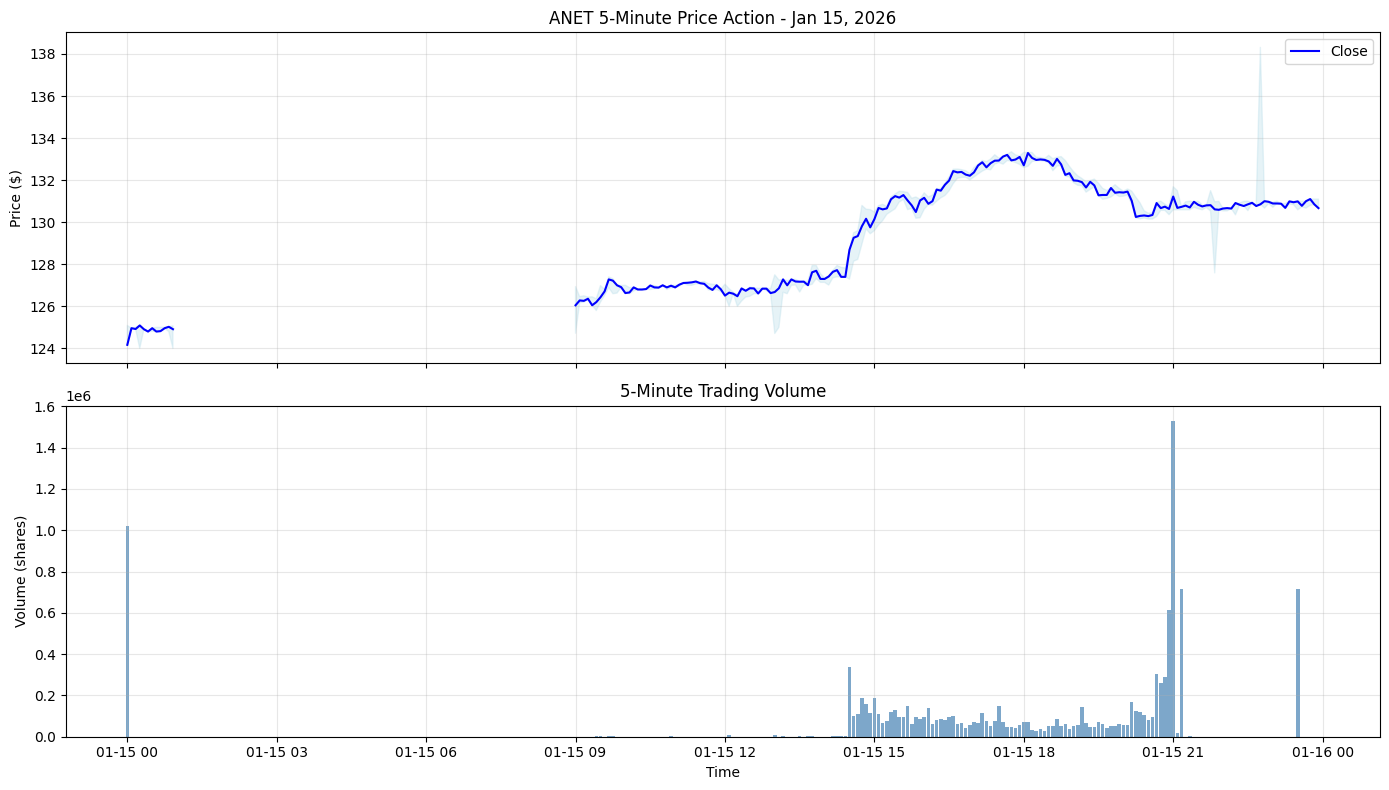

In [11]:
df_reset = df.reset_index(level='symbol', drop=True)

df_5min = df_reset.resample('5min').agg({
    'price': ['first', 'max', 'min', 'last'],
    'size': 'sum'
})

df_5min.columns = ['open', 'high', 'low', 'close', 'volume']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df_5min.index, df_5min['close'], label='Close', linewidth=1.5, color='blue')
ax1.fill_between(df_5min.index, df_5min['low'], df_5min['high'], alpha=0.3, color='lightblue')
ax1.set_ylabel('Price ($)')
ax1.set_title('ANET 5-Minute Price Action - Jan 15, 2026')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(df_5min.index, df_5min['volume'], width=0.003, alpha=0.7, color='steelblue')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume (shares)')
ax2.set_title('5-Minute Trading Volume')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

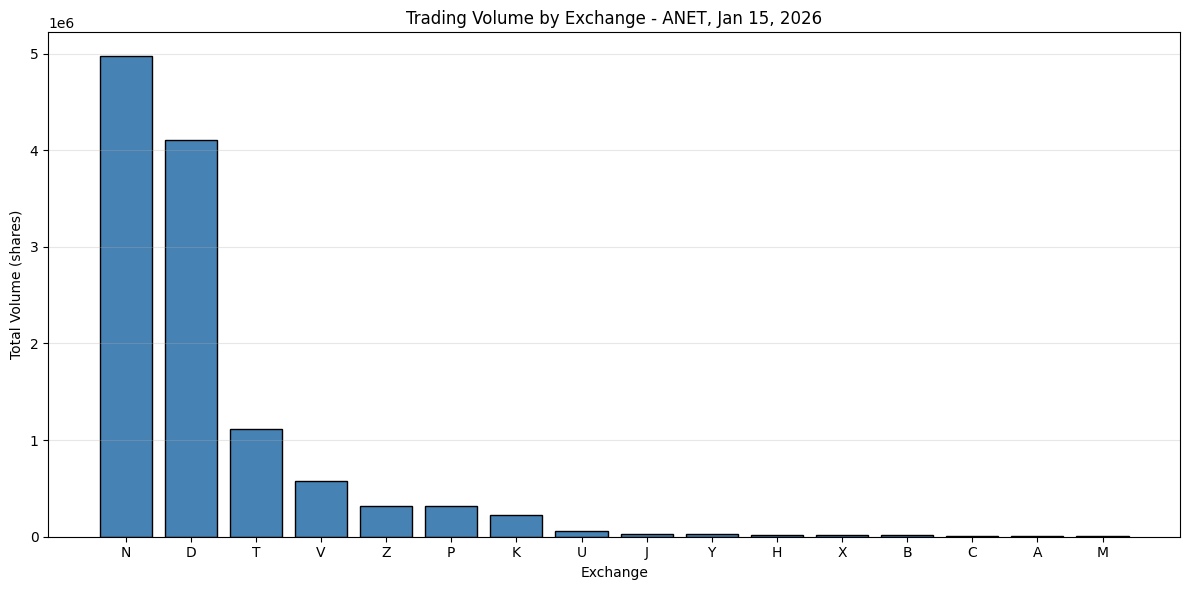

Total volume: 11,821,790 shares

Top 3 exchanges:
N: 4,971,541 shares (42.1%)
D: 4,107,201 shares (34.7%)
T: 1,112,764 shares (9.4%)


In [12]:
df = pd.read_csv('anet_exec_data.csv', parse_dates=['timestamp'], index_col=['symbol', 'timestamp'])
df_reset = df.reset_index(level='symbol', drop=True)

exchange_volume = df_reset.groupby('exchange')['size'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(exchange_volume.index, exchange_volume.values, color='steelblue', edgecolor='black')
plt.xlabel('Exchange')
plt.ylabel('Total Volume (shares)')
plt.title('Trading Volume by Exchange - ANET, Jan 15, 2026')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Total volume: {exchange_volume.sum():,.0f} shares")
print(f"\nTop 3 exchanges:") # N-NYSE, D-FINRA ADF, T-Nasdaq TRF, V-IEX
for exchange, volume in exchange_volume.head(3).items():
    pct = (volume / exchange_volume.sum() * 100)
    print(f"{exchange}: {volume:,.0f} shares ({pct:.1f}%)")